In [325]:
## Load expression data
library(data.table)
library(ggplot2)
setwd('/data6/Angelo/alexcc/isme17/')
d = fread('tpm.txt')

s = read.csv('sample_data.txt', sep='\t')
rownames(d) <- d$Protein
d[d == 0] <- NA

#quick fix for mislabeled data
d[which(d$Genome == '14_0903_16_40cm_Bacteria_5660_68_9'),]$Taxon = 'Acidobacteria'

## Get all biosynthetic genes

## Get all NRPS / PKS genes

Read 795298 rows and 126 (of 126) columns from 0.611 GB file in 00:00:21


In [326]:
d[is.na(d)] <- 0

data = d[,7:length(d)]
data2 = data
d = d[which(rowSums(data2) < 10000),]
data = data[which(rowSums(data2) < 10000),]

d[d == 0] <- NA
data[data == 0] <- NA


In [327]:
cnames = read.csv('cluster_prots.txt',sep='\t')
clust_prots = d[which(d$Protein %in% cnames$Protein),]
clust_prots = merge(cnames, clust_prots, by='Protein')

clust_prots = clust_prots[-which(clust_prots$Phylum %in% c('unknown','RIF_CHLX', 'Planctomycetes', 'RIF_WS3X', 'Bacteroidetes', 'Armatimonadetes')),]

## Restrict all data to just the genomes that we have clusters for.
nrow(d)
d = d[which(d$Genome %in% clust_prots$Genome),]
data = d[,7:length(d)]
nrow(d)

#Number of genomes in our dataset with gene expression above threshold
length(unique(d$Genome))



[1] 794986

[1] 460083

[1] 331

In [4]:
#Number of total genes within BGCs expressed
nrow(clust_prots)

#Number of BGCs with any level of expression
length(unique(clust_prots$Scaffold))

[1] 3300

[1] 666

In [5]:
c2 = clust_prots
c2[is.na(c2)] = 0
clust_data = as.data.frame(rowSums(c2[,10:length(c2)]))
names(clust_data) <- c("Sum")
clust_data$Protein = clust_prots$Protein
clust_data$Phylum = clust_prots$Phylum
clust_data$Type = clust_prots$Type

head(clust_data)
unique(clust_data$Phylum)

Sum,Protein,Phylum,Type
37.5136760,14_0903_02_20cm_scaffold_107_9,Gammaproteobacteria,Bacteriocin
0.8236457,14_0903_02_20cm_scaffold_11527_14,Actinobacteria,Bacteriocin
12.7282650,14_0903_02_20cm_scaffold_11527_15,Actinobacteria,Bacteriocin
1.3076839,14_0903_02_20cm_scaffold_11527_4,Actinobacteria,Bacteriocin
10.8414201,14_0903_02_20cm_scaffold_11527_5,Actinobacteria,Bacteriocin
2.7279461,14_0903_02_20cm_scaffold_11527_6,Actinobacteria,Bacteriocin


[1] Gammaproteobacteria Actinobacteria      Betaproteobacteria 
 [4] Alphaproteobacteria Proteobacteria      Acidobacteria      
 [7] Gemmatimonadetes    Verrucomicrobia     ANG-CHLX           
[10] Chloroflexi         Actinomycetales     Deltaproteobacteria
[13] Rokubacteria        Nitrospirae         Myxococcales       
[16] RIF-WS3X           
20 Levels: Acidobacteria Actinobacteria Actinomycetales ... Verrucomicrobia

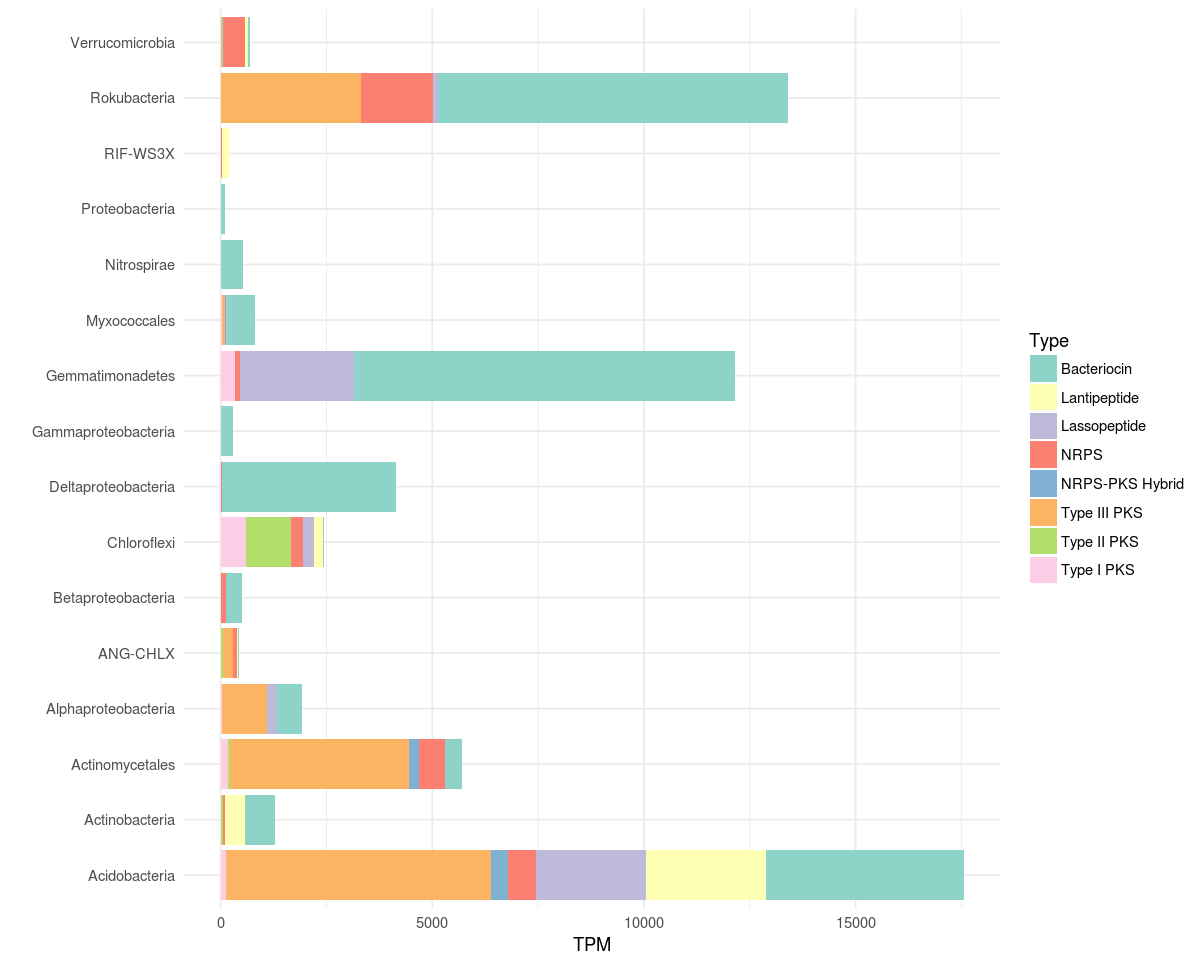

In [6]:
options(repr.plot.width=10, repr.plot.height=8)
p <- ggplot(clust_data, aes(Phylum, Sum, fill=Type))
p + geom_bar(stat = 'identity', aes(fill=Type)) + coord_flip() + theme_minimal() + xlab("") + ylab("TPM") + scale_fill_brewer(palette = "Set3")


In [7]:
## Get list of proteins that have NRP / PKS domains
domain_prot_names = read.csv('nrps_pks.txt', sep='\t')
domain_prot_names$Protein = as.character(domain_prot_names$Protein)
domain_prots = clust_prots[which(clust_prots$Protein %in% domain_prot_names$Protein),]

# domain_prots = domain_prots[-which(domain_prots$Taxon == 'unknown'),]
#Total number of NRPS / PKS genes expressed
# nrow(domain_prots)

# # Total number of gene clusters these genes came from
# length(unique(domain_prots$Scaffold))

In [8]:
## General picture of expression

data_domains = domain_prots[,10:length(domain_prots)]
d2 = data_domains
d2[is.na(d2)] = 0
dd_df = as.data.frame(rowSums(d2))
names(dd_df) <- c("Sum")
# dd_df$Sum = log10(0.000001+dd_df$Sum)
dd_df$Protein = domain_prots$Protein
dd_df$Taxon = domain_prots$Phylum
library(ggplot2)
dd_df = dd_df[order(-dd_df$Sum),]
head(dd_df)

,Sum,Protein,Taxon
3041,7.357734,14_1009_16_40cm_scaffold_21416_5,Verrucomicrobia
1011,6.560074,14_0903_16_40cm_scaffold_34599_3,Acidobacteria
1808,5.023045,14_1009_02_40cm_scaffold_1432_6,Chloroflexi
2174,4.891708,14_1009_09_30cm_scaffold_7505_10,Deltaproteobacteria
1809,4.827482,14_1009_02_40cm_scaffold_1432_7,Chloroflexi
1850,4.185981,14_1009_02_40cm_scaffold_719_7,Gemmatimonadetes


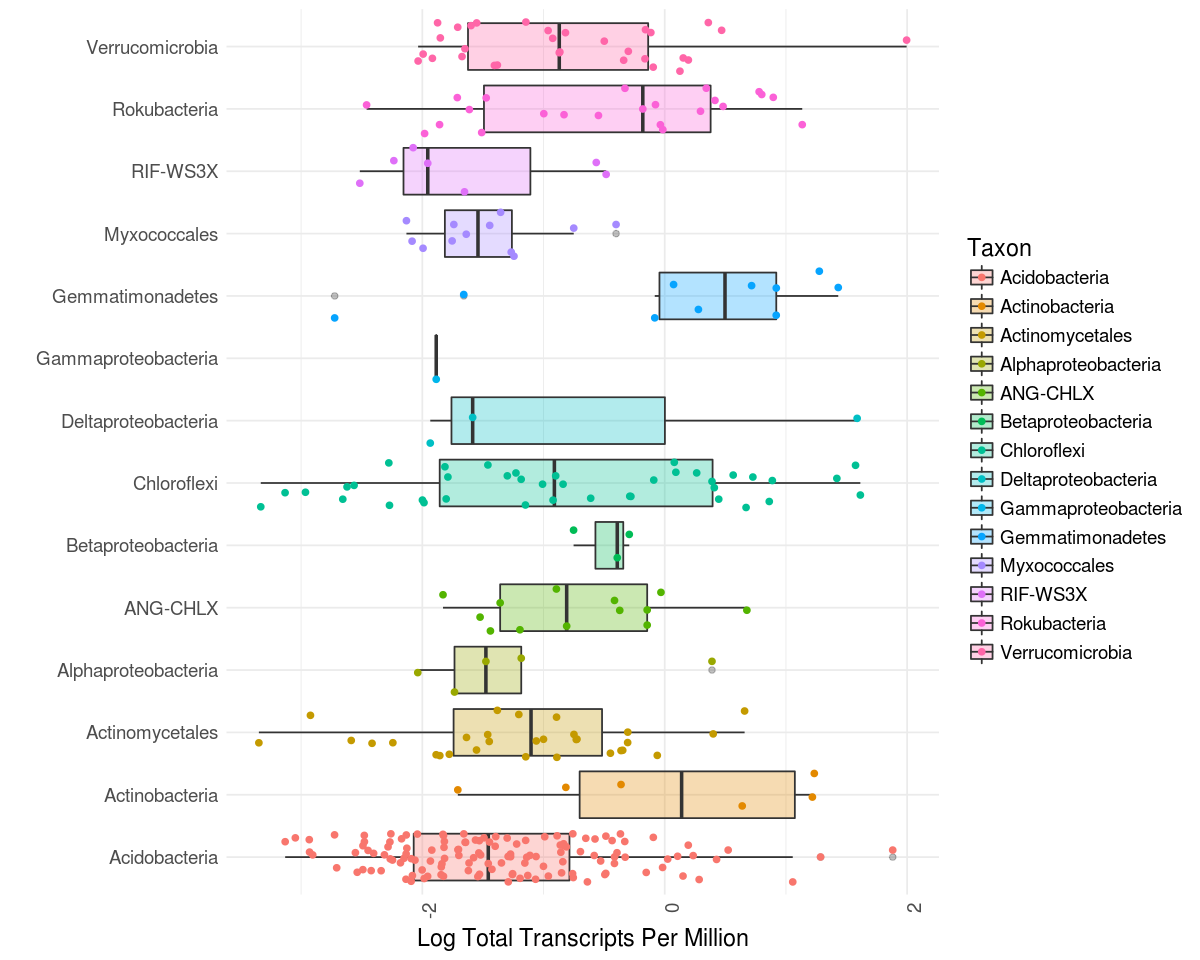

In [500]:
# pdf(file='fig1.pdf', width = 10, height=8)
options(repr.plot.width=10, repr.plot.height=8)
p <- ggplot(dd_df, aes(Taxon, log(Sum), fill=Taxon))
p + geom_boxplot(alpha = 0.3) + geom_jitter(aes(colour = Taxon)) + ylab("Log Total Transcripts Per Million") + 
theme_minimal() + coord_flip() + xlab("") + theme(text = element_text(size=14),
        axis.text.x = element_text(angle=90, hjust=1)) 
# dev.off()

In [10]:
## Rank genes by expression 
clust_prot_percentiles = list()
data2 = data
data2[is.na(data2)] = 0

for (genome in unique(d$Genome)){
    test = data2[which(d$Genome == genome),]
    test_df = as.data.frame(rowSums(test))
    names(test_df) <- c("Sum")
    test_df$Protein = d[which(d$Genome == genome),]$Protein
    perc.rank <- function(x) trunc(rank(x))/length(x)
    my.df <- within(test_df, xr <- perc.rank(Sum))
    clust_prot_percentiles = c(clust_prot_percentiles, my.df[which(my.df$Protein %in% domain_prot_names$Protein),]$xr)
}


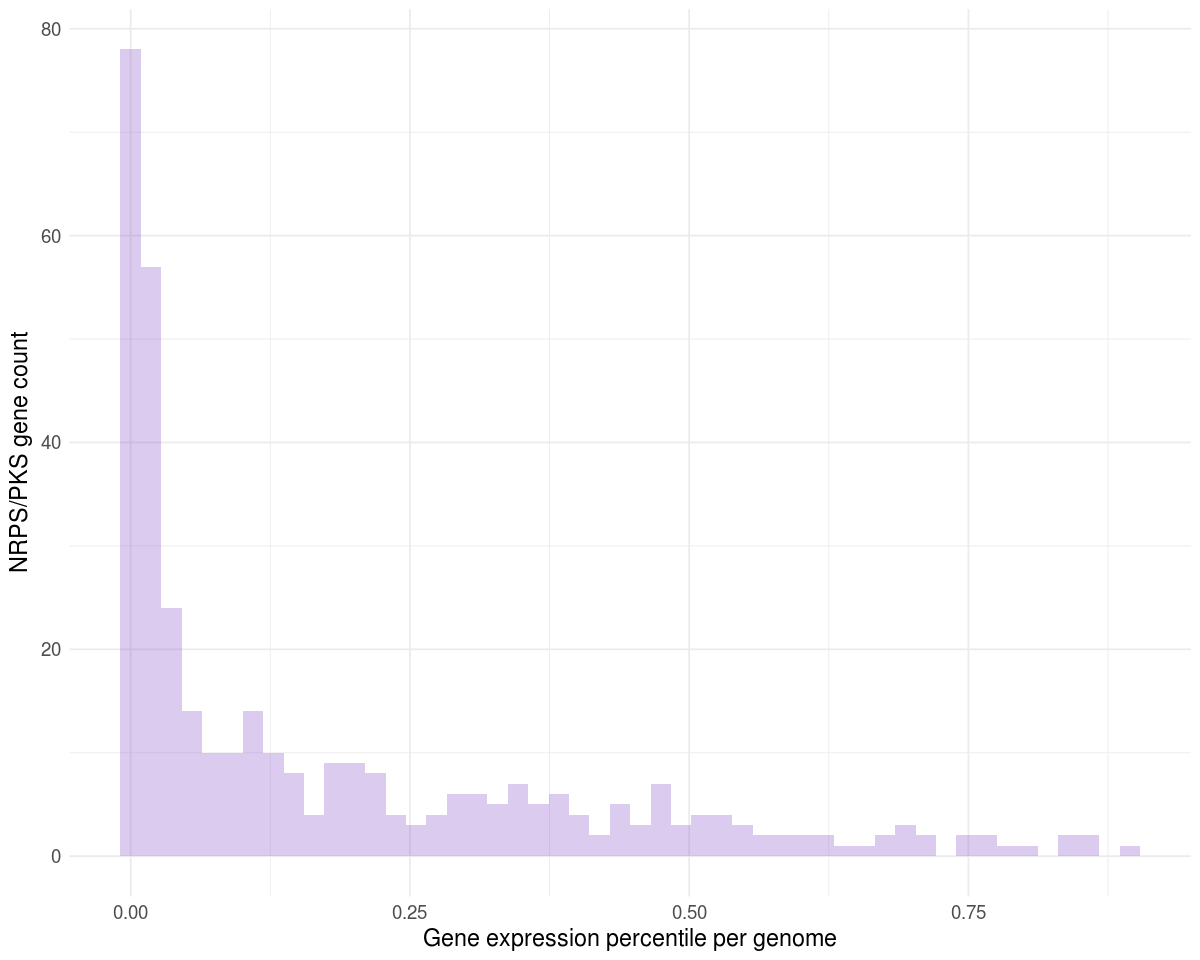

In [501]:
#Plot ranks of NRPS/PKS genes
test = as.numeric(clust_prot_percentiles)

# Plot
# pdf(file='fig2.pdf', width=10, height=2)
qplot(test, geom="histogram", alpha=I(0.3), bins=50, fill=I("#8953ca")) + theme_minimal() + ylab("NRPS/PKS gene count") + xlab("Gene expression percentile per genome") + theme(text = element_text(size=14)) 
    ## % of genomes with detectable expression that express BGCs

# dev.off()
## How highly expressed are BGCs in genomes?

In [12]:
## Plot % of NRPS/PKS genes expressed vs Total number of expressed genes observed
number_genes_per_genome = list()
percentage_biosynthetic = list()

for (genome in unique(d$Genome)){

    # number of genes
    g_num = length(which(d$Genome == genome))
    nrp_exp = length(which(d[which(d$Genome == genome),]$Protein %in% domain_prot_names$Protein))
    nrp_tot = length(which(domain_prot_names$Genome == genome))
    if (nrp_tot != 0) {
    number_genes_per_genome = c(number_genes_per_genome, g_num)
    percentage_biosynthetic = c(percentage_biosynthetic, nrp_exp/nrp_tot)
    }
}

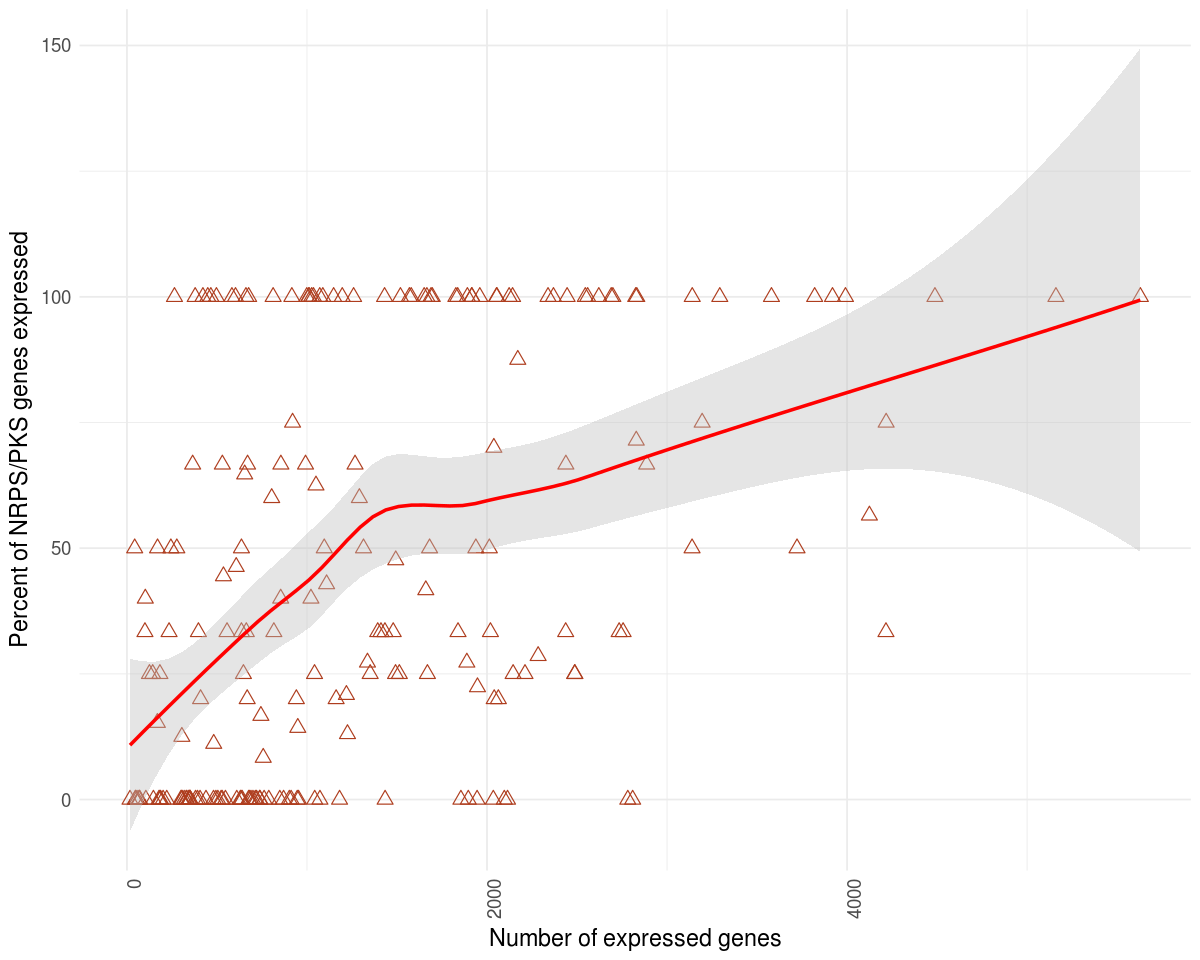

In [502]:
# pdf(file='fig3.pdf', width=10, height=7)
qplot(x = as.numeric(number_genes_per_genome), y=as.numeric(percentage_biosynthetic)*100, geom='point', size=I(3), shape=I(2), colour=I("#ae3d1e")) + 
geom_smooth(method = "loess", fill='grey', colour = "red") + theme_minimal() + xlab("Number of expressed genes") + ylab("Percent of NRPS/PKS genes expressed") + theme(text = element_text(size=14),
        axis.text.x = element_text(angle=90, hjust=1))

# dev.off()

# WGCNA Section

In [32]:
library(data.table)
library(ggplot2)
library(RColorBrewer)
library(pheatmap)
library(reshape2)
library(superheat)
library(WGCNA)
library(flashClust)
library(igraph)

d[is.na(d)] <- 0
data[is.na(data)] <- 0

In [49]:
genomes_to_test = c('14_0903_05_20cm_Chloroflexi_387_50_7', '14_0903_12_30cm_Bacteria_1108_73_5', '14_1009_16_30cm_Actinobacteria_9682_72_9',
                   '14_0903_13_30cm_Proteobacteria_5023_70_7', '14_0903_13_20cm_Proteobacteria_1234_70_6', '14_0903_05_20cm_Micromonosporales_397_71_6',
                   '14_0903_12_40cm_Bacteria_10609_55_11')

#Change this value to change which genome is analyzed
## From poster: ANG1 = 14_0903_12_40cm_Bacteria_10609_55_11, ANG2 = 14_0903_13_30cm_Proteobacteria_5023_70_7, 
## ANG3 = 14_0903_05_20cm_Chloroflexi_387_50_7, ANG4 = 14_1009_16_30cm_Actinobacteria_9682_72_9

genome = genomes_to_test[3]
genome
genome_data = as.matrix(data[which(d$Genome == genome),])
rownames(genome_data) = d$Protein[which(d$Genome == genome)]

## MANUALLY INSPECT PLOT AND REMOVE ANY EXTREMELY LARGE OUTLIERS
# plot(rowSums(genome_data))
# genome_data = genome_data[which(rowSums(genome_data) < 5000),] ## CHANGE VALUE FOR EACH GENOME

[1] "14_1009_16_30cm_Actinobacteria_9682_72_9"

In [50]:
## WGCNA
wgcna_data = t(genome_data)

# WGCNA
test = goodSamplesGenes(wgcna_data, minFraction = 0.25)
ncol(wgcna_data)
length(which(test$goodGenes == TRUE))
length(which(test$goodSamples == TRUE))

wgcna_data = wgcna_data[which(test$goodSamples == TRUE),which(test$goodGenes == TRUE)]
goodSamplesGenes(wgcna_data)$allOK


 Flagging genes and samples with too many missing values...
  ..step 1


[1] 4124

[1] 4124

[1] 120

 Flagging genes and samples with too many missing values...
  ..step 1


[1] TRUE

In [51]:
### Pick soft threshold level by approximating scale free network

powers = c(c(1:10), seq(from = 12, to=25, by=2));
sft=pickSoftThreshold(wgcna_data,dataIsExpr = TRUE, RsquaredCut = 0.80, powerVector = powers,corFnc = cor,corOptions = list(use = 'p'),networkType = "signed")

   Power SFT.R.sq   slope truncated.R.sq mean.k. median.k. max.k.
1      1  0.20300  4.9600          0.954 2610.00  2590.000 3080.0
2      2  0.07370  1.3000          0.927 1680.00  1650.000 2330.0
3      3  0.00061  0.0719          0.911 1100.00  1060.000 1800.0
4      4  0.07990 -0.6270          0.899  738.00   692.000 1400.0
5      5  0.24400 -0.9820          0.882  502.00   456.000 1110.0
6      6  0.43900 -1.2400          0.893  348.00   303.000  896.0
7      7  0.58900 -1.4300          0.909  246.00   204.000  730.0
8      8  0.68400 -1.5400          0.910  176.00   138.000  602.0
9      9  0.76600 -1.5900          0.932  129.00    94.800  502.0
10    10  0.80400 -1.6300          0.934   95.50    65.500  422.0
11    12  0.86900 -1.6500          0.951   54.90    32.100  308.0
12    14  0.89000 -1.6200          0.953   33.30    16.300  231.0
13    16  0.89800 -1.5800          0.957   21.20     8.520  178.0
14    18  0.90100 -1.5400          0.957   14.10     4.550  140.0
15    20  

In [52]:
# Create adjacency matrix
A2 = adjacency(wgcna_data, type="signed", corOptions = list(use='p'), power= sft$powerEstimate)
# head(A2)

#If you really want to visualize it...
# sampleTree = flashClust(as.dist(1-A2), method = "average") 
# plot(sampleTree, main = "Sample clustering to detect outliers", sub="", xlab="", cex.lab = 1.5, cex.axis = 1.5, cex.main = 2)

 ..done.


dynamicMods
   0    1    2    3    4 
2643 1101  242   70   68 

dynamicColors
     blue     brown      grey turquoise    yellow 
      242        70      2643      1101        68 

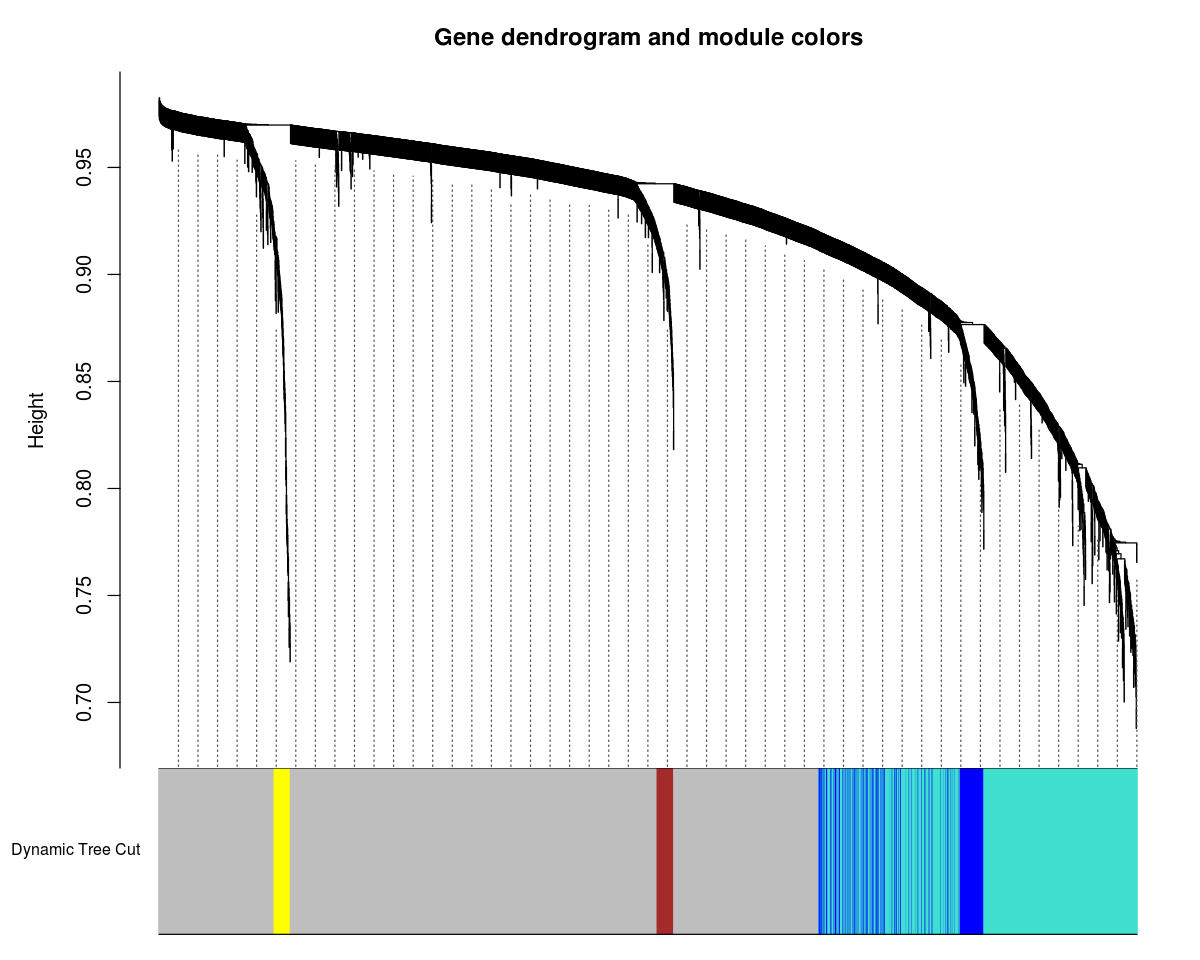

In [61]:
# Create TOM matrix
TOM=TOMsimilarity(A2)
dissTOM=1-TOM
# head(as.dist(na.omit(dissTOM)))
dissTOM[is.na(dissTOM)] <- 0;
geneTree = flashClust(as.dist(dissTOM),method="average")
# plot(geneTree, xlab="", sub="",cex=0.3);

# Gene Module detection
minModuleSize = 15;
geneTree$height <- round(geneTree$height,6)
dynamicMods = cutreeDynamic(dendro = geneTree,distM = dissTOM,  method="hybrid", minClusterSize = minModuleSize, deepSplit= FALSE, cutHeight=0.92);
table(dynamicMods)
dynamicColors = labels2colors(dynamicMods)
table(dynamicColors)
plotDendroAndColors(geneTree, dynamicColors, "Dynamic Tree Cut", dendroLabels = FALSE, hang = 0.03, addGuide = TRUE, guideHang = 0.05, main = "Gene dendrogram and module colors")


In [20]:
#set the diagonal of the dissimilarity to NA 
diag(dissTOM) = NA;

#Visualize the Tom plot. Raise the dissimilarity matrix to a power  to bring out the module structure
sizeGrWindow(7,7)


In [21]:
# TOMplot(dissTOM^4, geneTree, as.character(dynamicColors))

In [62]:
#Identify modules enriched in secondary metabolite genes

modules = c()
best = c()
module_colors= setdiff(unique(dynamicColors), "grey")
for (color in module_colors){
    module=rownames(genome_data)[which(dynamicColors==color)]
    modules = c(modules,module)
    
    clust_prots_found = length(module[which(module %in% clust_prots$Protein)])
    significance = phyper(clust_prots_found, length(module), nrow(genome_data) - clust_prots_found, length(module) - clust_prots_found, lower.tail = FALSE)
    
    if (significance < 0.05 && length(module[which(module %in% clust_prots$Protein)]) > 1){
        best = module
        print(significance)
        print(color)
        print(module[which(module %in% clust_prots$Protein)])    
        print(length(module[which(module %in% clust_prots$Protein)]))
        print(length(module[which(module %in% domain_prot_names$Protein)]))        
        print(length(module))
        print("****")

    }
#     print(d[which(d$Protein %in% module),]$Pathway)
#     modules = rbind(modules, module)
#     write.table(module, sep="\t", row.names=FALSE, col.names=FALSE,quote=FALSE)
}


[1] 5.001026e-11
[1] "yellow"
 [1] "14_1009_16_30cm_scaffold_680_114"  "14_1009_16_30cm_scaffold_4660_29" 
 [3] "14_1009_16_30cm_scaffold_4660_24"  "14_1009_16_30cm_scaffold_90_344"  
 [5] "14_1009_16_30cm_scaffold_4660_25"  "14_1009_16_30cm_scaffold_4660_7"  
 [7] "14_1009_16_30cm_scaffold_1220_1"   "14_1009_16_30cm_scaffold_26576_16"
 [9] "14_1009_16_30cm_scaffold_1220_29"  "14_1009_16_30cm_scaffold_4660_21" 
[11] "14_1009_16_30cm_scaffold_4660_27" 
[1] 11
[1] 1
[1] 68
[1] "****"


In [63]:
## Export module t a graph - visualize it

e = exportNetworkToCytoscape(TOM,threshold = 0.1, weighted=TRUE, nodeNames=rownames(genome_data), nodeAttr=dynamicMods)
nrow(e$nodeData)
nrow(e$edgeData)
graph_df = data.frame('from'=as.character(),'to'=as.character(),'weight'=as.numeric())
for (row in 1:nrow(e$edgeData)){
    if (e$edgeData$fromNode[row] %in% best && e$edgeData$toNode[row] %in% best){
        temp_df = data.frame(e$edgeData$fromNode[row],
                             e$edgeData$toNode[row],
                             e$edgeData$weight[row])
        names(temp_df) = c('from','to','weight')
        graph_df = rbind(graph_df,temp_df)
        
        ## Add KEGG
        
        ## Add is in cluster?
    }
}

nrow(graph_df)
uniq_nodes = unique(c(as.character(graph_df$to), as.character(graph_df$from)))
length(uniq_nodes)

[1] 4077

[1] 1006720

[1] 1152

[1] 67

In [64]:
graph_df$from = gsub("14_1009_16_30cm_scaffold_", "", graph_df$from)
graph_df$to = gsub("14_1009_16_30cm_scaffold_", "", graph_df$to)

g1 <- graph_from_data_frame(graph_df, directed=F)

In [66]:
# svg(file='net1.svg')
plot(g1, 
     vertex.color="#448897", edge.color='#53be4b', edge.width = 0.4, vertex.size=5,
     layout=layout.drl)
# dev.off()

png 
  2

In [67]:
kegg = fread('/data6/Angelo/transcriptomics/old/kegg.tab', sep='\t')

Read 3369949 rows and 17 (of 17) columns from 0.561 GB file in 00:00:14


In [68]:
## Show KEGG Annotations of genes in module
options(repr.matrix.max.rows = 100)
head(kegg[which(kegg$ORF %in% best),],n=100)

No.,Bin,ORF,Length,KO,Name,Description,Pathway,Unique?,Module,Reliability,E-value,Hit score,HMM threshold,Hit length,HMM mean length,HMM sd length
2785974,14_1009_16_30cm_Actinobacteria_9682_72_9,14_1009_16_30cm_scaffold_1163_2,361,-,-,-,-,-,-,no hit,-,-,-,361,-,-
2785978,14_1009_16_30cm_Actinobacteria_9682_72_9,14_1009_16_30cm_scaffold_1163_6,72,-,-,-,-,-,-,no hit,-,-,-,72,-,-
2785979,14_1009_16_30cm_Actinobacteria_9682_72_9,14_1009_16_30cm_scaffold_1163_7,190,-,-,-,-,-,-,no hit,-,-,-,190,-,-
2785980,14_1009_16_30cm_Actinobacteria_9682_72_9,14_1009_16_30cm_scaffold_1163_8,94,-,-,-,-,-,-,no hit,-,-,-,94,-,-
2785981,14_1009_16_30cm_Actinobacteria_9682_72_9,14_1009_16_30cm_scaffold_1163_9,82,-,-,-,-,-,-,no hit,-,-,-,82,-,-
2785983,14_1009_16_30cm_Actinobacteria_9682_72_9,14_1009_16_30cm_scaffold_1163_11,185,K03088,"SIG3.2, rpoE","RNA polymerase sigma-70 factor, ECF subfamily",-,-,-,questionable,1.9e-06,34.6,49.3,185,191.4,32.1
2785985,14_1009_16_30cm_Actinobacteria_9682_72_9,14_1009_16_30cm_scaffold_1163_13,273,-,-,-,-,-,-,no hit,-,-,-,273,-,-
2785986,14_1009_16_30cm_Actinobacteria_9682_72_9,14_1009_16_30cm_scaffold_1163_14,87,-,-,-,-,-,-,no hit,-,-,-,87,-,-
2785989,14_1009_16_30cm_Actinobacteria_9682_72_9,14_1009_16_30cm_scaffold_1163_17,395,K00754,E2.4.1.-,ko00051 Fructose and mannose metabolism,Fructose and mannose metabolism,+,-,questionable,9.2e-29,108.3,197.1,395,498.4,186.4
2785990,14_1009_16_30cm_Actinobacteria_9682_72_9,14_1009_16_30cm_scaffold_1163_18,342,-,-,-,-,-,-,no hit,-,-,-,342,-,-


In [48]:
uniq_nodes[which(uniq_nodes %in% clust_prots$Protein)]

[1] "14_0903_05_20cm_scaffold_1552_11" "14_0903_05_20cm_scaffold_334_12" 
[3] "14_0903_05_20cm_scaffold_2457_8"  "14_0903_05_20cm_scaffold_349_14" 
[5] "14_0903_05_20cm_scaffold_334_17"

# Random Forest Section

In [523]:
library('randomForest')
library("miscTools")
library(plyr)

In [550]:
## normalize genomes's gene expression as a percentile

# For ANG1 = 14_0903_12_40cm_Bacteria_10609_55_11 #r^2 = 0.90
# For ANG3 = 14_0903_05_20cm_Chloroflexi_387_50_7 #r^2 = 0.96
# For ANG4 = 14_1009_16_30cm_Actinobacteria_9682_72_9


genome = '14_1009_16_30cm_Actinobacteria_9682_72_9'

genome_to_predict = data[which(d$Genome == genome),]
rownames(genome_to_predict) = d[which(d$Genome == genome),]$Protein
test_data_s = scale(genome_to_predict)
rownames(test_data_s) = rownames(genome_to_predict)

In [551]:
#Transform data
d[is.na(d)] <- 0
data[is.na(data)] <- 0

data3 = data
data3$Genome = d$Genome

In [552]:
#Create response and predictor variables
predict_x = ddply(data3, "Genome", numcolwise(sum))
rownames(predict_x) = predict_x$Genome
predict_x$Genome = NULL

x_rows = rownames(predict_x)
predict_x = t(predict_x)
colnames(predict_x) = paste('A', gsub("_", "x", x_rows), sep='')

In [553]:
predict_y = test_data_s[which(rownames(test_data_s) %in% domain_prot_names$Protein),]
nrow(predict_y)
predict_y = colSums(predict_y)

[1] 26

In [554]:
ncol(predict_x)
length(predict_y)

[1] 331

[1] 120

In [555]:
predict_df = cbind(predict_x, data.frame(y=predict_y))

In [556]:
#Run random forest
rf <- randomForest(y ~ ., data=predict_df, ntree=500)

In [557]:
print(rf)

print(rSquared(predict_df$y, predict_df$y - predict(rf, predict_df[1:ncol(predict_df)-1])))


Call:
 randomForest(formula = y ~ ., data = predict_df, ntree = 500) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 110

          Mean of squared residuals: 0.08696583
                    % Var explained: 44.2
          [,1]
[1,] 0.9142942


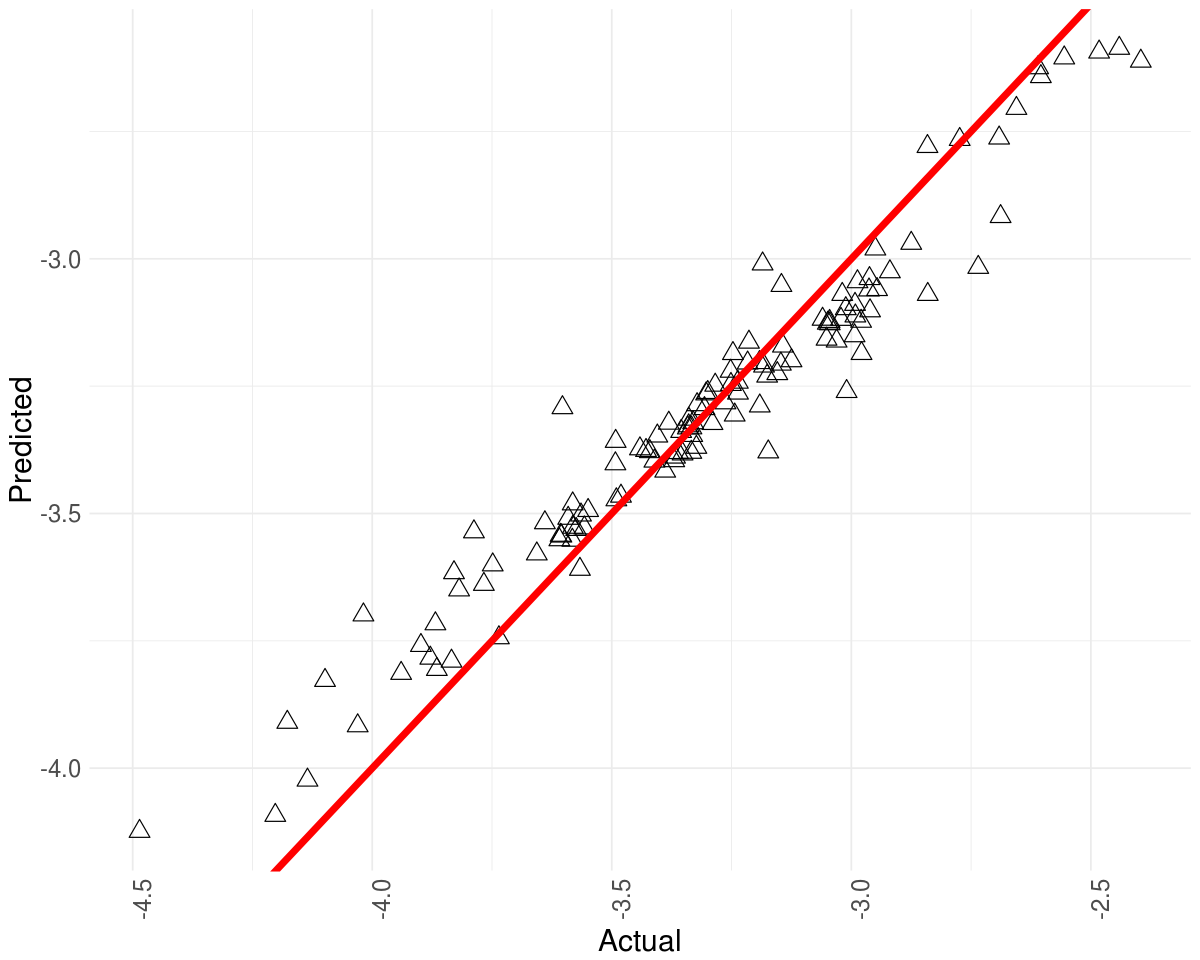

In [558]:
#Plot predicted vs actual data
# pdf(file='fig6.pdf')
p <- ggplot(aes(x=actual, y=pred),
  data=data.frame(actual=predict_df$y, pred=predict(rf, predict_df[1:ncol(predict_df)-1])))
p + geom_point(size=4, shape=2) + geom_abline(color="red",size=2) + theme_minimal() + xlab("Actual") + ylab("Predicted") + theme(text = element_text(size=18),
        axis.text.x = element_text(angle=90, hjust=1))
# dev.off()

In [561]:

#Get and plot 6 most important features
library(ggRandomForests)
gg_v = gg_vimp(rf, nvar = 6)

NULL

Warning message:
“Ignoring unknown parameters: se, span”Warning message:
“Ignoring unknown parameters: se, span”`geom_smooth()` using method = 'loess'


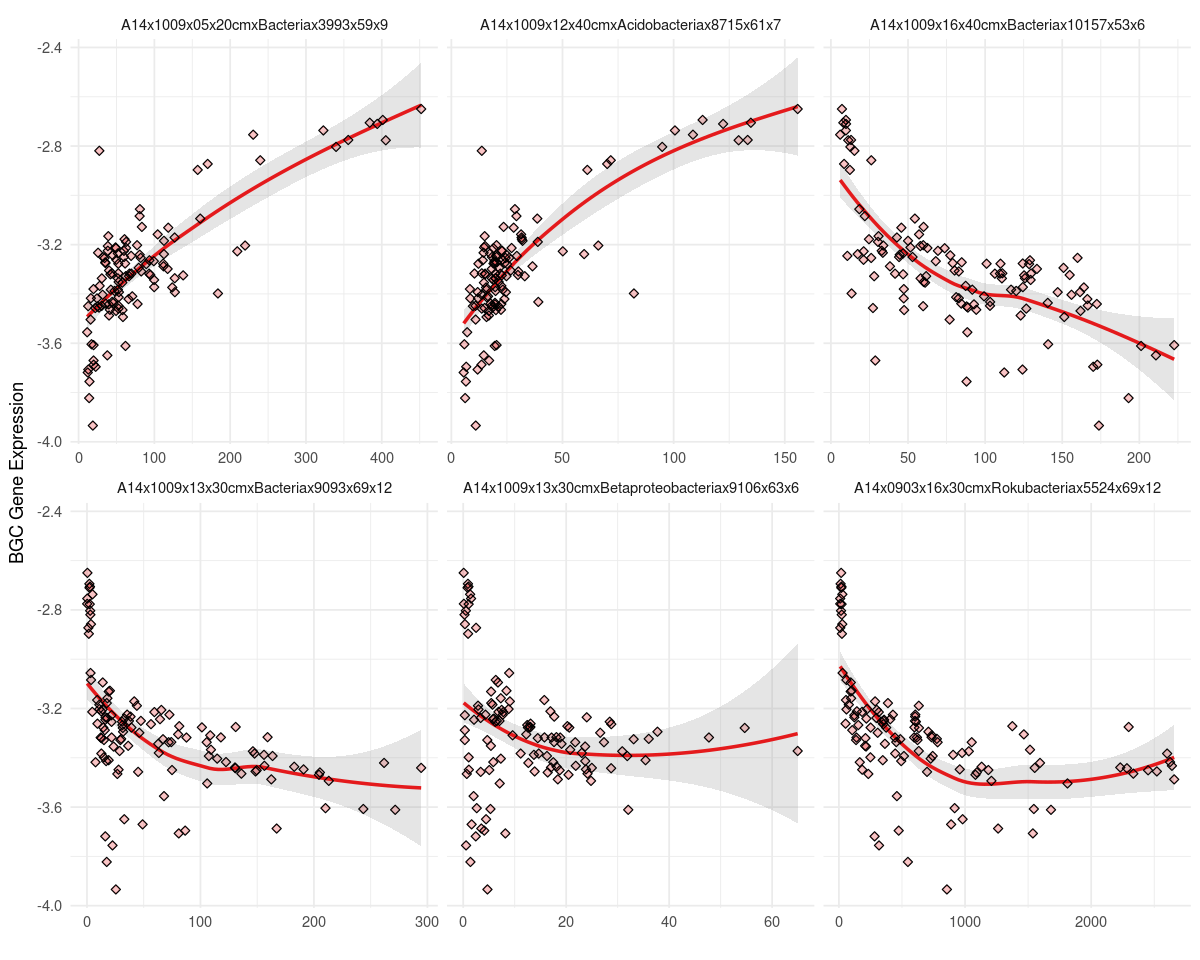

In [562]:
gg_var <- gg_variable(rf)
xvar <- gg_v$vars
nrow(xvar)
# pdf(file='fig8.pdf')
plot(gg_var, xvar=xvar, panel=TRUE, se=.95, span=1.2, alpha=.25, colour='#e41a1c') + geom_point(shape=5, alpha=1) +theme_minimal() + ylab("BGC Gene Expression")
# dev.off()

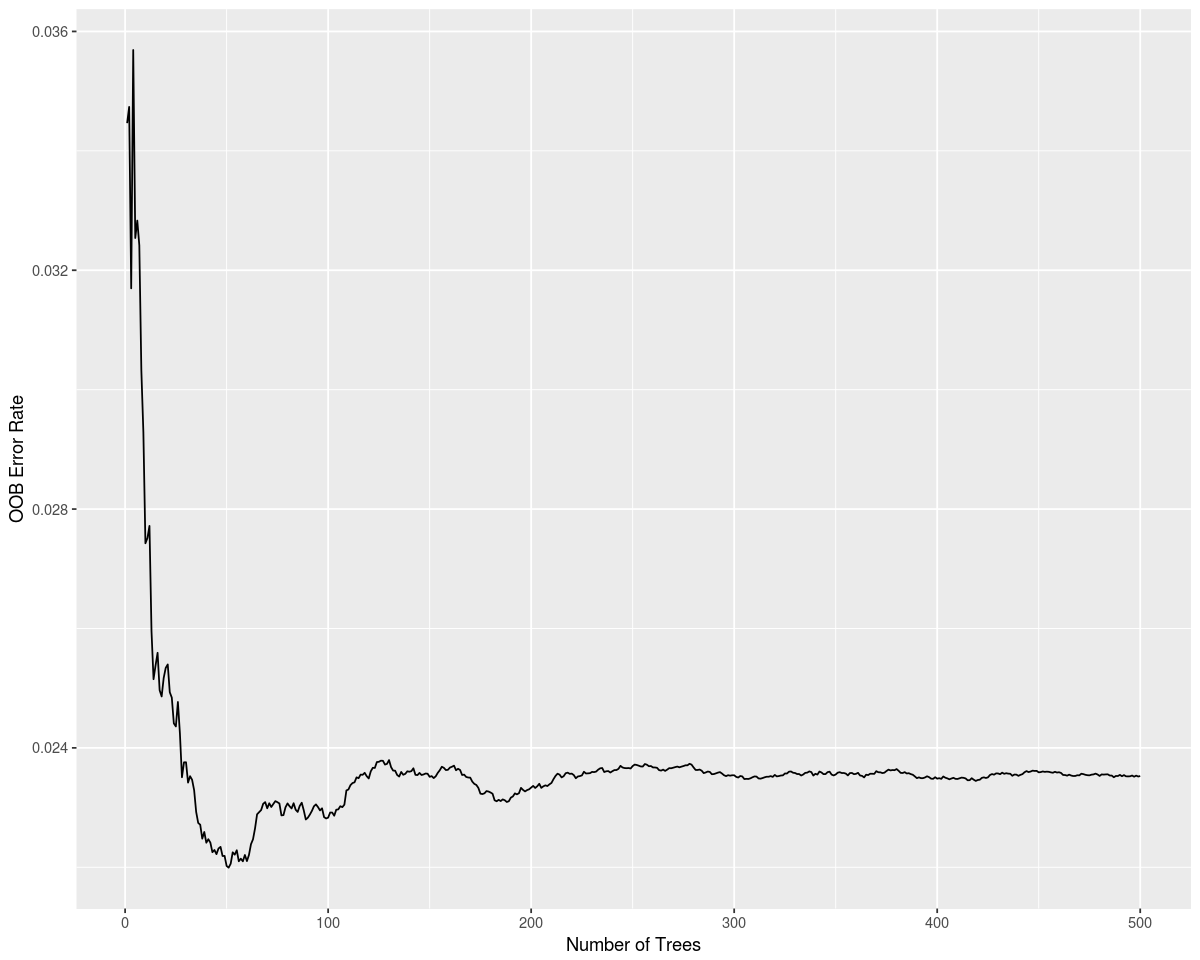

In [447]:
# Plot OOB Error by number of trees
plot(gg_error(rf))